## Importando Bibliotecas e Base de Dados

In [1]:
# bibliotecas padrões
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# bibliotecas para NLP
import nltk
from nltk import FreqDist
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
from unidecode import unidecode
from nltk.corpus import stopwords
from spacy.lang.pt.stop_words import STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer

# bibliotecas para modelagem
from sklearn.svm import SVC
from sklearn.metrics import precision_recall_fscore_support, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, cross_validate

dados = pd.read_csv('final_dados_feedbacks.csv')

In [2]:
dados.head()

,Data,Feedback,Perguntas,Sentimento
0,28/03/2020,Não,"Sobre o OpenTalk, com Robson del Fiol. Você te...",positivo
1,29/03/2020,"Eu indicaria ele abordar um tema novo, não só ...","Sobre o OpenTalk, com Robson del Fiol. Você te...",negativo
2,04/04/2020,As histórias que ele conta e a maneira como ab...,Sobre a palestra do Caê: Liderança Pessoal [CO...,positivo
3,04/04/2020,"Adorei as coisas que ele falou, foi muuuito le...",Sobre a palestra do Caê: Liderança Pessoal [CO...,positivo
4,04/04/2020,"Só agradecimento, cada vez que falo com o Sérg...",Sobre a palestra do Caê: Liderança Pessoal [CO...,positivo


In [3]:
dados.shape

(1180, 4)

## Limpeza do Texto

In [4]:
# Eliminando perguntas que não fazem sentido do dataframe
dados = dados.loc[(dados['Perguntas'] != 'Escreva uma autoavaliação da sua EXECUÇÃO na etapa de PROTOTIPAGEM (VimVer)') &
         (dados['Perguntas'] != 'Escreva uma autoavaliação da sua execução na etapa de MAPEAMENTO (VimVer). OBS: Etapa iniciada no penúltimo encontro.') &
         (dados['Perguntas'] != 'Escreva uma autoavaliação da sua EXECUÇÃO na etapa de IDEAÇÃO (VimVer). OBS: Etapa iniciada no penúltimo encontro.') &
         (dados['Perguntas'] != 'Escreva uma autoavaliação da sua EXECUÇÃO na etapa de EXPERIMENTAÇÃO (VimVer)')]

In [5]:
dados.Feedback = dados.Feedback.str.lower()
dados['Feedback'] = dados['Feedback'].apply(lambda x: unidecode(x))
dados[['Data', 'Feedback', 'Sentimento']].head(4)

,Data,Feedback,Sentimento
0,28/03/2020,nao,positivo
1,29/03/2020,"eu indicaria ele abordar um tema novo, nao so ...",negativo
2,04/04/2020,as historias que ele conta e a maneira como ab...,positivo
3,04/04/2020,"adorei as coisas que ele falou, foi muuuito le...",positivo


In [6]:
def RemovePunctuation(feedback):
    feedback = re.sub(r"[-|0-9]", "", feedback).lower()
    feedback = re.sub(r'[-./?!,":;()\']', ' ', feedback).lower()
    return (feedback)

lista_feedback = []
lista_feedback = [RemovePunctuation(feedback) for feedback in dados.Feedback]

dados.Feedback = lista_feedback

In [7]:
dados['Feedback'] = dados['Feedback'].apply(lambda x: x.strip())
dados['Feedback'] = dados['Feedback'].apply(lambda x: x.replace("  ", " "))
dados[['Data', 'Feedback', 'Sentimento']].head(4)

,Data,Feedback,Sentimento
0,28/03/2020,nao,positivo
1,29/03/2020,eu indicaria ele abordar um tema novo nao so o...,negativo
2,04/04/2020,as historias que ele conta e a maneira como ab...,positivo
3,04/04/2020,adorei as coisas que ele falou foi muuuito leg...,positivo


In [8]:
dados.drop_duplicates(subset=['Feedback'], inplace=True)
dados.shape

(784, 4)

## Pré-Processamento

In [9]:
nlp = word_tokenize

In [10]:
dados['Contagem_palavras'] = dados['Feedback'].apply(lambda x: len(str(x).split(" ")))
dados[['Data', 'Feedback', 'Sentimento', 'Contagem_palavras']].head(4)

,Data,Feedback,Sentimento,Contagem_palavras
0,28/03/2020,nao,positivo,1
1,29/03/2020,eu indicaria ele abordar um tema novo nao so o...,negativo,24
2,04/04/2020,as historias que ele conta e a maneira como ab...,positivo,12
3,04/04/2020,adorei as coisas que ele falou foi muuuito leg...,positivo,12


In [48]:
def RemoveStopWords(feedback):
    palavras = [i for i in feedback.split() if not i in corr_palavras]
    return (" ".join(palavras))

In [49]:
lemmatizer = WordNetLemmatizer()
def Lemmatization(feedback):
  palavras = []
  for w in feedback.split():
    palavras.append(lemmatizer.lemmatize(w))
  return (" ".join(palavras))

## Balanceando Dados

In [50]:
dados.Sentimento.value_counts()

positivo    600
negativo    184
Name: Sentimento, dtype: int64

In [51]:
sentimento=['Negativo', 'Positivo']
le = LabelEncoder()
le.fit(dados['Sentimento'])
target_encoded = le.transform(dados['Sentimento'])

In [52]:
dados['target_encoded'] = target_encoded

In [53]:
dados.target_encoded.value_counts()

1    600
0    184
Name: target_encoded, dtype: int64

In [54]:
count_class_1, count_class_0 = dados.target_encoded.value_counts()

In [55]:
# Divide by class
dados_class_0 = dados[dados['target_encoded'] == 0]
dados_class_1 = dados[dados['target_encoded'] == 1]

Random under-sampling:
1    184
0    184
Name: target_encoded, dtype: int64


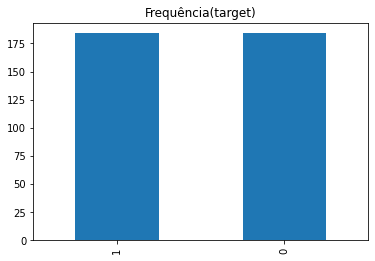

In [56]:
dados_class_0_under = dados_class_0.sample(count_class_0, random_state=42)
dados_class_1_under = dados_class_1.sample(count_class_0, random_state=42)
dados = pd.concat([dados_class_0_under, dados_class_1_under], axis=0)

print('Random under-sampling:')
print(dados.target_encoded.value_counts())

dados.target_encoded.value_counts().plot(kind='bar', title='Frequência(target)');

## Validando Modelo

In [57]:
# função para transformar o texto em Matrix Count e TFIDF
def bow(feedbacks):
    bag_of_words_transformer = TfidfVectorizer()
    mx = bag_of_words_transformer.fit_transform(feedbacks).todense()
    terms = bag_of_words_transformer.get_feature_names()
    dados_tfidf = pd.DataFrame(mx, columns=terms, index=feedbacks)
    
    return (dados_tfidf)

In [58]:
dados = dados[dados['Contagem_palavras'] > 2]

In [59]:
feedback_lem = dados['Feedback'].apply(lambda x: Lemmatization(x))
dados_tfidf = bow(feedback_lem)
target_encoded = dados['target_encoded']

In [60]:
dados_corr = dados_tfidf.copy()
dados_corr['target_encoded'] = list(target_encoded)

In [61]:
corr = dados_corr.corr()
corr_palavras = list(corr[(corr['target_encoded'] < 0.06) & (corr['target_encoded'] > -0.06)].index)

In [62]:
df = pd.DataFrame(data={"Palavras_corr": corr_palavras})
df.to_csv("./palavras_corr.csv", sep=',',index=False)

In [63]:
lista_feedback = []
lista_feedback = [RemoveStopWords(feedback) for feedback in dados.Feedback]

In [64]:
dados['Feedback_palavras_irrelevantes'] = lista_feedback

In [65]:
# função para transformar o texto em Matrix Count e TFIDF
def bow(feedbacks):
    bag_of_words_transformer = TfidfVectorizer(binary=True, max_features=550,
                                               smooth_idf=False, sublinear_tf=True)
    mx = bag_of_words_transformer.fit_transform(feedbacks).todense()
    terms = bag_of_words_transformer.get_feature_names()
    dados_tfidf = pd.DataFrame(mx, columns=terms, index=feedbacks)
    
    return (dados_tfidf)

In [66]:
feedback_lem = dados['Feedback_palavras_irrelevantes'].apply(lambda x: Lemmatization(x))
dados_tfidf = bow(feedback_lem)

In [67]:
svc = SVC(random_state=42, probability=True)

In [68]:
# scores TFIDF Vectorizer
scores_tfidf = cross_validate(svc, dados_tfidf, target_encoded, cv=5,
                        scoring=('f1_macro', 'f1_weighted', 'recall_macro', 'precision_macro', 'accuracy'))

scores_tfidf = pd.DataFrame.from_dict(scores_tfidf)

scores_tfidf = pd.DataFrame(scores_tfidf.mean()).T
scores_tfidf.index = ['TFIDF']
scores_tfidf.drop(columns=['fit_time', 'score_time'], inplace=True)
scores_tfidf

,test_f1_macro,test_f1_weighted,test_recall_macro,test_precision_macro,test_accuracy
TFIDF,0.881163,0.88126,0.880888,0.884154,0.881469


## Deploy do Modelo

In [69]:
from joblib import dump, load

In [70]:
tfidf = TfidfVectorizer(binary=True, max_features=550, smooth_idf=False, sublinear_tf=True)
tfidf.fit(feedback_lem)

TfidfVectorizer(binary=True, max_features=550, smooth_idf=False,
                sublinear_tf=True)

In [71]:
dump(tfidf, 'vectorizer_tfidf.joblib')

['vectorizer_tfidf.joblib']

In [72]:
svc.fit(dados_tfidf, target_encoded)

SVC(probability=True, random_state=42)

In [73]:
dump(svc, 'model_svc.joblib')

['model_svc.joblib']